In [1]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_04_29_2019')
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice

In [2]:
fluctuations_df = shift.get_fluctuations_df('res_df_test_light_source_04_29_2019.csv')
def var_theor(x, M):
    return x+1/M*x**2
def as_si(x, ndp):
    """Returns number in scientific format for latex. For PyPlot when latex output is needed. 
    Latex distibtuion must be installed on the machine. Also set  plt.rcParams["text.usetex"] =True
    Parameters
    ----------
    x
        the input number
    ndp : int
        desired number of decimals
    """
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'${m:s}\times 10^{{{e:d}}}$'.format(m=m, e=int(e))

In [90]:
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
i_to_photoel = 1/N_to_I
N = sum_channel_to_photoelectrons*fluctuations_df["ch2_amplitude"].values
coef = 2*sum_channel_to_photoelectrons**2
varN = coef*fluctuations_df["var_of_ch1_amplitude"].values
signal_to_noise_level = coef*1e-7 
fluctuations_df['N'] = N
fluctuations_df['varN'] = varN
fluctuations_df = fluctuations_df.sort_values('N').reset_index(drop=True)
#fitting
y = varN-N
x = N**2
Mfit = np.mean(x**2)/np.mean(x*y)
save_to_config("test_light_source_theta", 1/Mfit)
def my_plot(ax, order=[2,0,1], error_bar=0):
#     from matplotlib import rc
#     rc("text", usetex=True)
#     plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
#     fig, ax = plt.subplots(figsize=(15, 7.5))
    ax.errorbar(fluctuations_df['N'],fluctuations_df['varN'],marker='.',linestyle='None',yerr=error_bar,color='b',
               label='Measurement with the test light source', markersize=10)
    x_aux = np.linspace(0, ax.get_xlim()[1],100)
    ax.plot(x_aux, x_aux,color='blue',linestyle='--',
            label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
    ax.plot(x_aux, var_theor(x_aux, Mfit), color='tab:red', linestyle='-',
            label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle+\theta\langle\mathcal{N}\rangle^2$")
    ax.plot([0, x_aux[-1]],[signal_to_noise_level, signal_to_noise_level],
            color='black',label='Signal/Noise = 1')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    ax.text(0.1,0.48,r"$\theta$"+r" = \SI{"+f"{1/Mfit:.2e}"+r"}{}",transform=ax.transAxes)
    ax.set_ylabel(r"Photoelectron count"+"\n"+r" variance var$\left(\mathcal{N}\right)$")
    ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
#     return fig, ax

In [91]:
signal_to_noise_level

230152866.59139344

In [92]:
zoom_x = 0.7e7
zoom_y = 1.7e8

In [93]:
small_fl_df = fluctuations_df[fluctuations_df['N'] < zoom_x]
varN_error_fit = np.sqrt(((small_fl_df['varN']-var_theor(small_fl_df['N'], Mfit))**2).mean())
varN_error_fit

2688549.487873511

In [94]:
from fur.path_assistant import get_plot_style_sheet
import matplotlib as mpl
mpl.use("pgf")
plt.style.use(get_plot_style_sheet("prab"))
plt.rc('pgf', preamble=\
       r'\usepackage{amsmath}'
       +r'\usepackage{unicode-math}'
       +r'\usepackage{amsthm}'
       +r'\setmainfont{Times}'
       +r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}'
       +r'\let\mathbb\relax'
       +r'\DeclareMathAlphabet{\mathbb}{U}{msb}{m}{n}'
       +r'\usepackage{siunitx}')
plt.rc('lines', markersize=8)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,12))
my_plot(ax1)
# Create a Rectangle patch
import matplotlib.patches as patches
rect = patches.Rectangle((0,0), zoom_x, zoom_y,linewidth=3,edgecolor='r',facecolor='none', zorder=100)
# Add the patch to the Axes
ax1.add_patch(rect)
N1, N2, N3 = (fluctuations_df['N'][41], fluctuations_df['N'][42], fluctuations_df['N'].iloc[-1])
ax1.axvspan(0, N1, facecolor='green', alpha=0.2)
ax1.axvspan(N2, N3 , facecolor='yellow', alpha=0.2)
ax1.annotate('Subtraction of noise\n is required',((0+N1)/2, 0.7e9),ha='center')#,fontsize=sec_f)
ax1.annotate(r'Signal/Noise$\gg 1$',((N2+N3)/2,3.4e9),ha='center')#,fontsize=sec_f)
ax1.annotate('Noise level',(0.55*(N2+N3),0.3e9),ha='center')#,fontsize=20)
# ax1.set_title('Test light source. Different ND filters.', fontsize=24)
ax1.set_xlim(0,3.5e7)
ax1.set_ylim(0,ax1.get_ylim()[1]*0.95)


my_plot(ax2, order=[0,1], error_bar=varN_error_fit)
ax2.set_ylim(0, zoom_y)
ax2.set_xlim(0, zoom_x)
ax2.text(0.8, 0.15, r'Inferred statistical' +'\n'+' error = \SI{'+f"{varN_error_fit:.1e}"+r"}{}",
        transform=ax2.transAxes,
          ha='center', va='center')#, fontsize=sec_f)
ax1.text(-0.15, 1.1, '(a)', transform=ax1.transAxes, fontsize=36, va='top', ha='left')
ax2.text(-0.15, 1.1, '(b)', transform=ax2.transAxes, fontsize=36, va='top', ha='left')
fig.subplots_adjust(hspace=0.3)


ft = ax1.yaxis.get_major_formatter()
ft.format_ticks = lambda x: [f"{y:.1e}".split('e')[0] for y in x]

output_path = path_assistant.get_PRL_images_dir().fi("test_light_source.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

/var/folders/gy/wdr0lhkn46n55mh2jbgygp500000gn/T/ipykernel_57386/3507813588.py:49: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [69]:
varN_error_fit

2688549.487873511

In [47]:
# fig, ax = my_plot()
# # Create a Rectangle patch
# import matplotlib.patches as patches
# rect = patches.Rectangle((0,0), zoom_x, zoom_y,linewidth=3,edgecolor='r',facecolor='none', zorder=100)
# # Add the patch to the Axes
# ax.add_patch(rect)
# N1, N2, N3 = (fluctuations_df['N'][41], fluctuations_df['N'][42], fluctuations_df['N'].iloc[-1])
# ax.axvspan(0, N1, facecolor='green', alpha=0.2)
# ax.axvspan(N2, N3 , facecolor='yellow', alpha=0.2)
# sec_f = 24
# ax.annotate('Subtraction of noise\n is required',((0+N1)/2, 1.1e9),ha='center',fontsize=sec_f)
# ax.annotate(r'Signal/Noise$\gg 1$',((N2+N3)/2,3.2e9),ha='center',fontsize=sec_f)
# ax.annotate('noise level',(0.6*(N2+N3),0.3e9),ha='center',fontsize=20)
# # ax.set_title('Test light source. Different ND filters.', fontsize=24)
# ax.set_xlim(0,3.5e7)
# ax.set_ylim(0,ax.get_ylim()[1]*0.95)
# plt.savefig(shift.get_results_dir().fi("test_light_source_large_scale.png"),
#             dpi=300, bbox_inches='tight')
# plt.show()

In [48]:
save_to_config("varN_error_fit", varN_error_fit)

In [49]:
# fig, ax = my_plot(order=[0,1], error_bar=varN_error_fit)
# ax.set_ylim(0, zoom_y)
# ax.set_xlim(0,zoom_x)
# ax.text(0.56,0.1,'Inferred statistical error = {:s}'.format(as_si(varN_error_fit, 1)),
#          transform=ax.transAxes,fontsize = sec_f)
# # ax.set_title('Test light source. Dirrefent ND filters. Zoomed in.', fontsize=24)
# plt.savefig(shift.get_results_dir().fi("test_light_source_small_scale.png"),
#             dpi=300, bbox_inches='tight')
# plt.show()

In [50]:
# import figure_arrange_scripts as ff
# hor_separ = 0.05
# v_space = 150
# fontsize = 175
# im_paths = [shift.get_results_dir().fi("test_light_source_large_scale.png"),
#             shift.get_results_dir().fi("test_light_source_small_scale.png")]
# output_path = path_assistant.get_PRL_images_dir().fi("test_light_source.png")

In [51]:
# ff.RowOfFigures(im_paths,output_path,
#                 hor_separ,v_space,fontsize,display_inline=1)

# Noise subtraction illustration

In [13]:
wfs = [
    "RefCurve_2019-04-30_6_132011.Wfm.csv",#"RefCurve_2019-04-29_10_174911.Wfm.csv",
    "RefCurve_2019-04-30_19_140624.Wfm.csv",#"RefCurve_2019-04-30_10_133304.Wfm.csv",#"RefCurve_2019-04-29_13_175756.Wfm.csv",
    "RefCurve_2019-04-30_14_134943.Wfm.csv"#"RefCurve_2019-04-29_19_181226.Wfm.csv"
]

In [14]:
import numpy as np
import pandas as pd
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var

In [15]:
res = []
for i, wfi in enumerate(wfs):
    wf = shift.get_waveform_path(wfi)
    nbins=2660
    filter_window_length=51
    filter_polyorder=3
    resampling_factor=10
    cut_start=125000
    cut_end=5000000
    ch1, ch2 = read_waveform(wf, csv=True)
    ch1 = ch1[cut_start:-cut_end]
    ch2 = ch2[cut_start:-cut_end]
    period = get_period(ch2,
                        filter_window_length=filter_window_length,
                        filter_polyorder=filter_polyorder,
                        resampling_factor=resampling_factor,
                        testing=False)
    output = {}
#     if i==2:
#         period = 2659.9813549980827
    get_fluctiation_and_noise_var(ch1, ch2, period, n_bins=nbins,
                                  show_plots=False, fit_method='lstsq',
                                  output_dic=output)
    res.append(output['var_ch1_df'])

In [16]:
for varch1_df in res:
    varch1_df['var_ch1'] = np.roll(varch1_df['var_ch1'].values, -400)

In [17]:
shift16 = path_assistant.PathAssistant('shift_03_16_2020')
meas_ROUND = pd.read_csv(shift16.get_results_dir().fi('meas_ROUND_03_16_2020.csv'), index_col=0)
meas_ROUND = meas_ROUND.sort_values(by='N',ignore_index=True)
def f(x, alpha):
    return x+alpha*x**2
import scipy.optimize
alpha = scipy.optimize.curve_fit(f, meas_ROUND['N'], meas_ROUND['varN'])[0][0]
def NfromVarN(vn):
    return (-1+np.sqrt(1+4*alpha*vn))/2/alpha

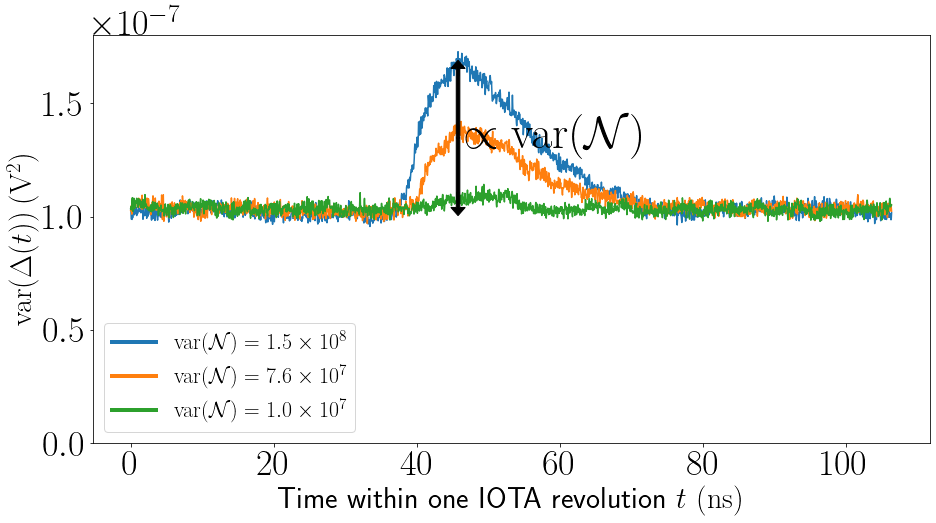

In [18]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})

fig, ax = plt.subplots(figsize=[15, 7.5])
for varch1_df, wf in zip(res,wfs):
    row = fluctuations_df[fluctuations_df['waveform_file']==wf]
#     valav = row['N'].values[0]
    valvar = row['varN'].values[0]
    valav = NfromVarN(valvar)
    
    ax.plot(0.04*varch1_df['t'],
            varch1_df['var_ch1'],
           label=
#             r'$I_\mathrm{beam} = \SI{'+f"{valav*N_to_I:.1f}"+'}{mA}$, '
#             +r'$\left<\mathcal{N}\right>=\SI{'
#             +f"{valav:.1e}"
#             +r'}{}$'
#             +r', '
            r'$\mathrm{var}(\mathcal{N})=\SI{'
            +f"{valvar:.1e}"
            +r'}{}$'
            )
ax.set_ylim(0, 1.8e-7)
ax.set_ylabel(r'$\mathrm{var}(\Delta(t))\;(\SI{}{V^2})$')
ax.set_xlabel(r'Time within one IOTA revolution $t$ $(\SI{}{ns})$')
varch1_df = res[0]
tmax = varch1_df['t'][np.argmax(varch1_df['var_ch1'])]*0.04
ma = np.max(varch1_df['var_ch1'])-0.02e-7
mi = np.min(varch1_df['var_ch1'])+0.03e-7
av = (mi+ma)/2

ax.arrow(tmax, av, 0, 0.85*(ma-av), head_width=2,
         head_length=0.1*(ma-av), fc='k', ec='k', width=0.5,
         zorder=100)
ax.arrow(tmax, av, 0, 0.85*(mi-av), head_width=2,
         head_length=0.1*(ma-av), fc='k', ec='k', width=0.5,
         zorder=100)
ax.annotate("$\propto \mathrm{var}(\mathcal{N})$", (tmax+1, av*0.97), fontsize=46)
leg = ax.legend(loc='lower left')
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
# plt.savefig(path_assistant.get_PRL_images_dir().fi("noise_filtering.png"),
#             dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# noise_level_V2 = res[2][-500:].mean()['var_ch1']
# noise_level = noise_level_V2*coef

# save_to_config("noise_level_V2", noise_level_V2)
# save_to_config("noise_level", noise_level)